In [ ]:
!git config --list

In [ ]:
!git clone https://github.com/shakir2018/Traffic-Signs-Recognition-Project.git

In [ ]:
import os
os.chdir('/content/Traffic-Signs-Recognition-Project') # Navigate to project

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!git lfs install

Updated git hooks.
Git LFS initialized.


In [ ]:
!find . -type f -size +99M

./german-traffic-sign-dataset.zip


In [ ]:
!git lfs track "german-traffic-sign-dataset.zip"

"german-traffic-sign-dataset.zip" already supported


In [ ]:
!git add .
!git add german-traffic-sign-dataset.zip
!git commit -main
!git push origin main

hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> Traffic-Signs-Recognition-Project
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached Traffic-Signs-Recognition-Project
hint: 
hint: See "git help submodule" for more information.
[main ed399f8] ain
 6 files changed, 4 insertions(+)
 create mode 100644 Plots/augmented_image.png
 create mode 100644 Plots/random_samples.png
 create mode 100644 Plots/training_set_plot.png
 create mode 100644 Plots/transformation_images.png
 create mode 160000 Traffic-Signs-Recognition-Project
 create mode 100644 german-traffic-sign-dataset.zip
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
C

In [ ]:
!git rm --cached Traffic-Signs-Recognition-Project
!git commit -m "Fix: Remove nested repository structure"
!git push origin main
os.chdir('/content/Traffic-Signs-Recognition-Project')

rm 'Traffic-Signs-Recognition-Project'
[main 78a84cb] Fix: Remove nested repository structure
 1 file changed, 1 deletion(-)
 delete mode 160000 Traffic-Signs-Recognition-Project
Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Delta compression using up to 2 threads
Compressing objects: 100% (2/2), done.
Writing objects: 100% (2/2), 254 bytes | 254.00 KiB/s, done.
Total 2 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/shakir2018/Traffic-Signs-Recognition-Project.git
   ed399f8..78a84cb  main -> main


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Traffic-Signs-Recognition-Project/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download harbhajansingh21/german-traffic-sign-dataset

Dataset URL: https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset
License(s): other
  0% 0.00/118M [00:00<?, ?B/s]
100% 118M/118M [00:00<00:00, 1.27GB/s]


In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
    ])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import matplotlib
import pickle
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from time import time
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import logging, datetime
logger = logging.getLogger()

warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 16})
warnings.filterwarnings('ignore')

In [ ]:
## Load the dataset in pickle file format on Google Colab
training_set = '/content/train.p'
validation_file = '/content/valid.p'
testing_file = '/content/test.p'

with open(training_set, mode='rb') as f:   #This opens each pickle file in binary read mode ('rb')
    train = pickle.load(f)                  #Loads the serialized data using pickle.load()
with open(validation_file, mode='rb') as f:  #The with statement ensures the files are properly closed after reading
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

## Extracting features and labels
train_x, train_y = train['features'], train['labels']
valid_x, valid_y = valid['features'], valid['labels']
test_x, test_y = test['features'], test['labels']


#Training_set used to train the model
#Validation_set Used to tune hyperparameters and monitor training progress
#Test_set Used for final model evaluation


In [ ]:
##Load the signnames csv data
signnames = pd.read_csv('/content/signname.csv')
signnames.set_index('ClassId', inplace=True)

In [ ]:
train_n = train_x.shape[0]
test_n = test_x.shape[0]
valid_n = valid_x.shape[0]

image_shape = train_x.shape[1:]
classes_n = len(np.unique(train_y))

print("Number of training examples =", train_n)
print("Numbeer of validationexamples =", valid_n)
print("Number of testing examples =", test_n)
print("Image data shape =", image_shape)
print("Number of classes =", classes_n)

Number of training examples = 34799
Numbeer of validationexamples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
## Exploratory visualization of the dataset
from collections import Counter

def getNameBylabel(label):
    return signnames.loc[label].SignName

counter = Counter(train_y)
mean = int(np.mean(list(Counter(train_y).values())))
min_val = np.min(list(Counter(train_y).values()))
max_val = np.max(list(Counter(train_y).values()))

print("Train sample in each class mean {} min {} max {}".format(mean, min_val, max_val))
print()
print("Common samples:")
for el in counter.most_common(10):
    print("'{}'".format(getNameBylabel(el[0])), 'Train samples: {}'.format(el[1]))

#The code: looks up a SignName from a signnames DataFrame using the label as an index.
#Counting occurrences of each label using Counter
#Calculating mean, minimum, and maximum samples per class
#Displaying the 10 most common classes

Train sample in each class mean 809 min 180 max 2010

Common samples:
'Speed limit (50km/h)' Train samples: 2010
'Speed limit (30km/h)' Train samples: 1980
'Yield' Train samples: 1920
'Priority road' Train samples: 1890
'Keep right' Train samples: 1860
'No passing for vehicles over 3.5 metric tons' Train samples: 1800
'Speed limit (70km/h)' Train samples: 1770
'Speed limit (80km/h)' Train samples: 1650
'Road work' Train samples: 1350
'No passing' Train samples: 1320


In [ ]:
for el in counter.most_common(10):
  print("'{}'".format(getNameBylabel(el[0])), 'train samples: {}'.format(el[1]))

'Speed limit (50km/h)' train samples: 2010
'Speed limit (30km/h)' train samples: 1980
'Yield' train samples: 1920
'Priority road' train samples: 1890
'Keep right' train samples: 1860
'No passing for vehicles over 3.5 metric tons' train samples: 1800
'Speed limit (70km/h)' train samples: 1770
'Speed limit (80km/h)' train samples: 1650
'Road work' train samples: 1350
'No passing' train samples: 1320


In [ ]:
##This helps identify class imbalance - classes with very few training samples that might need data augmentation or special handling during training.

print()               #Prints an empty line for visual separation/spacing
print("Rare samples:")
for el in sorted(counter.items(), key=lambda x: x[1])[:10]:
  print("'{}'".format(getNameBylabel(el[0])), 'train samples: {}'.format(el[1]))


Rare samples:
'Go straight or left' train samples: 180
'Dangerous curve to the left' train samples: 180
'Speed limit (20km/h)' train samples: 180
'End of no passing' train samples: 210
'End of no passing by vehicles over 3.5 metric' train samples: 210
'End of all speed and passing limits' train samples: 210
'Pedestrians' train samples: 210
'Bicycles crossing' train samples: 240
'Road narrows on the right' train samples: 240
'Keep left' train samples: 270



Rare samples:
'Go straight or left' train samples: 180
'Dangerous curve to the left' train samples: 180
'Speed limit (20km/h)' train samples: 180
'End of no passing' train samples: 210
'End of no passing by vehicles over 3.5 metric' train samples: 210
'End of all speed and passing limits' train samples: 210
'Pedestrians' train samples: 210
'Bicycles crossing' train samples: 240
'Road narrows on the right' train samples: 240
'Keep left' train samples: 270


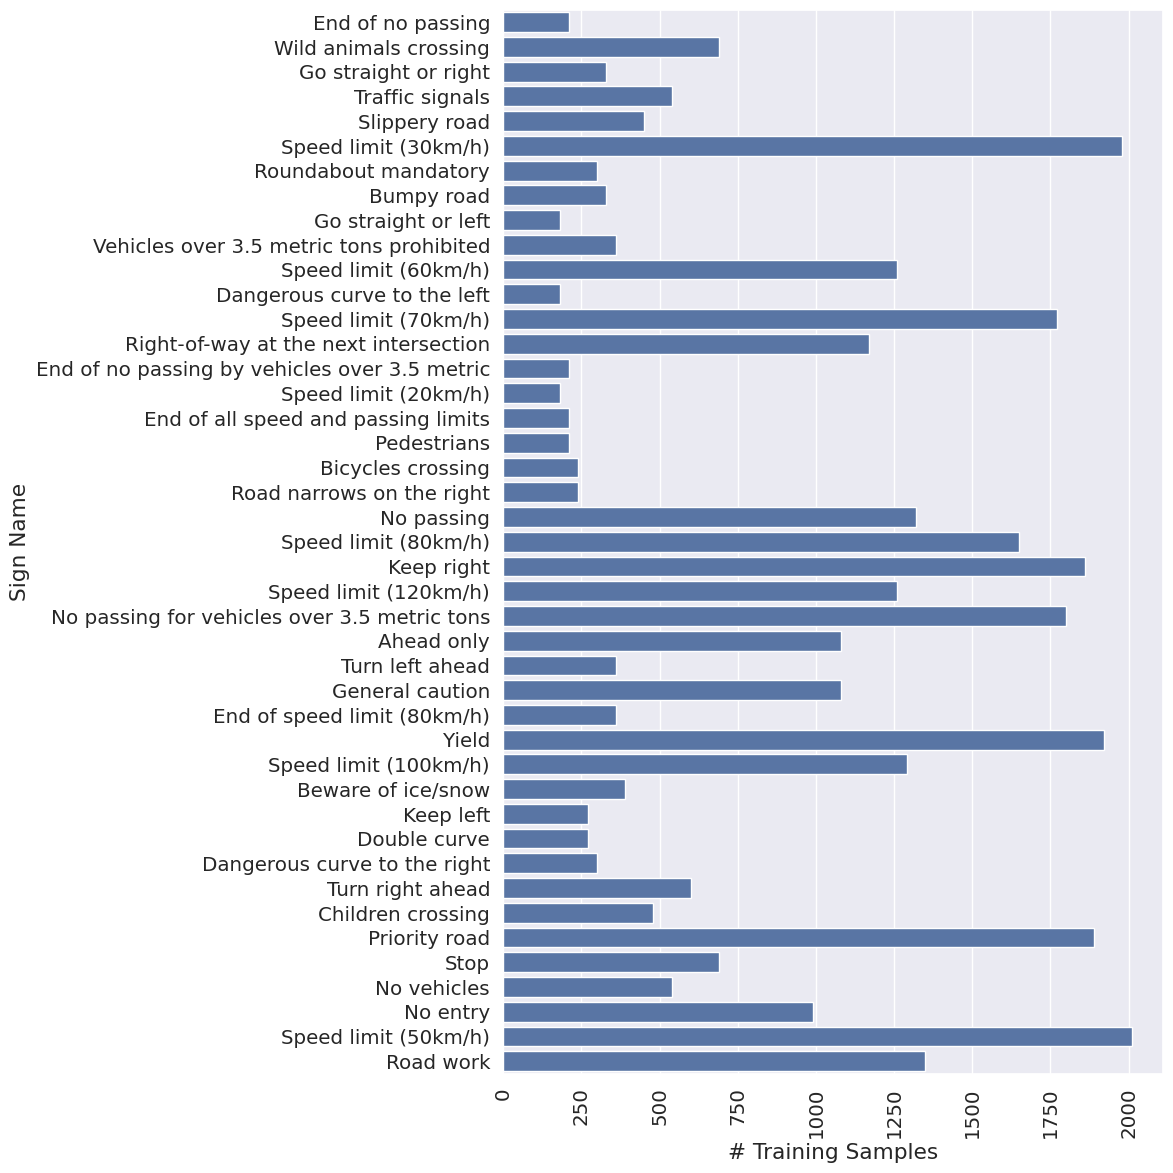

In [ ]:
##This helps identify class imbalance - classes with very few training samples that might need data augmentation or special handling during training.

print()               #Prints an empty line for visual separation/spacing
print("Rare samples:")
for el in sorted(counter.items(), key=lambda x: x[1])[:10]:
  print("'{}'".format(getNameBylabel(el[0])), 'train samples: {}'.format(el[1]))

import os
if not os.path.exists('Plots'):
    os.makedirs('Plots')

counts = pd.DataFrame(columns=['sign_label', 'training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(getNameBylabel)
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count', y='sign', data=counts,orient='h')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.tight_layout()
plt.savefig('Plots/training_set_plot.png')

In [ ]:
def getSamples(n_max=1):
  selected = list()
  for current_label in range(classes_n):
    found = 0
    while found < n_max:
      index = np.random.randint(len(train_y))
      if current_label == train_y[index]:
        selected.append(index)
        found+=1
  assert len(selected) == classes_n*n_max
  return list(selected)

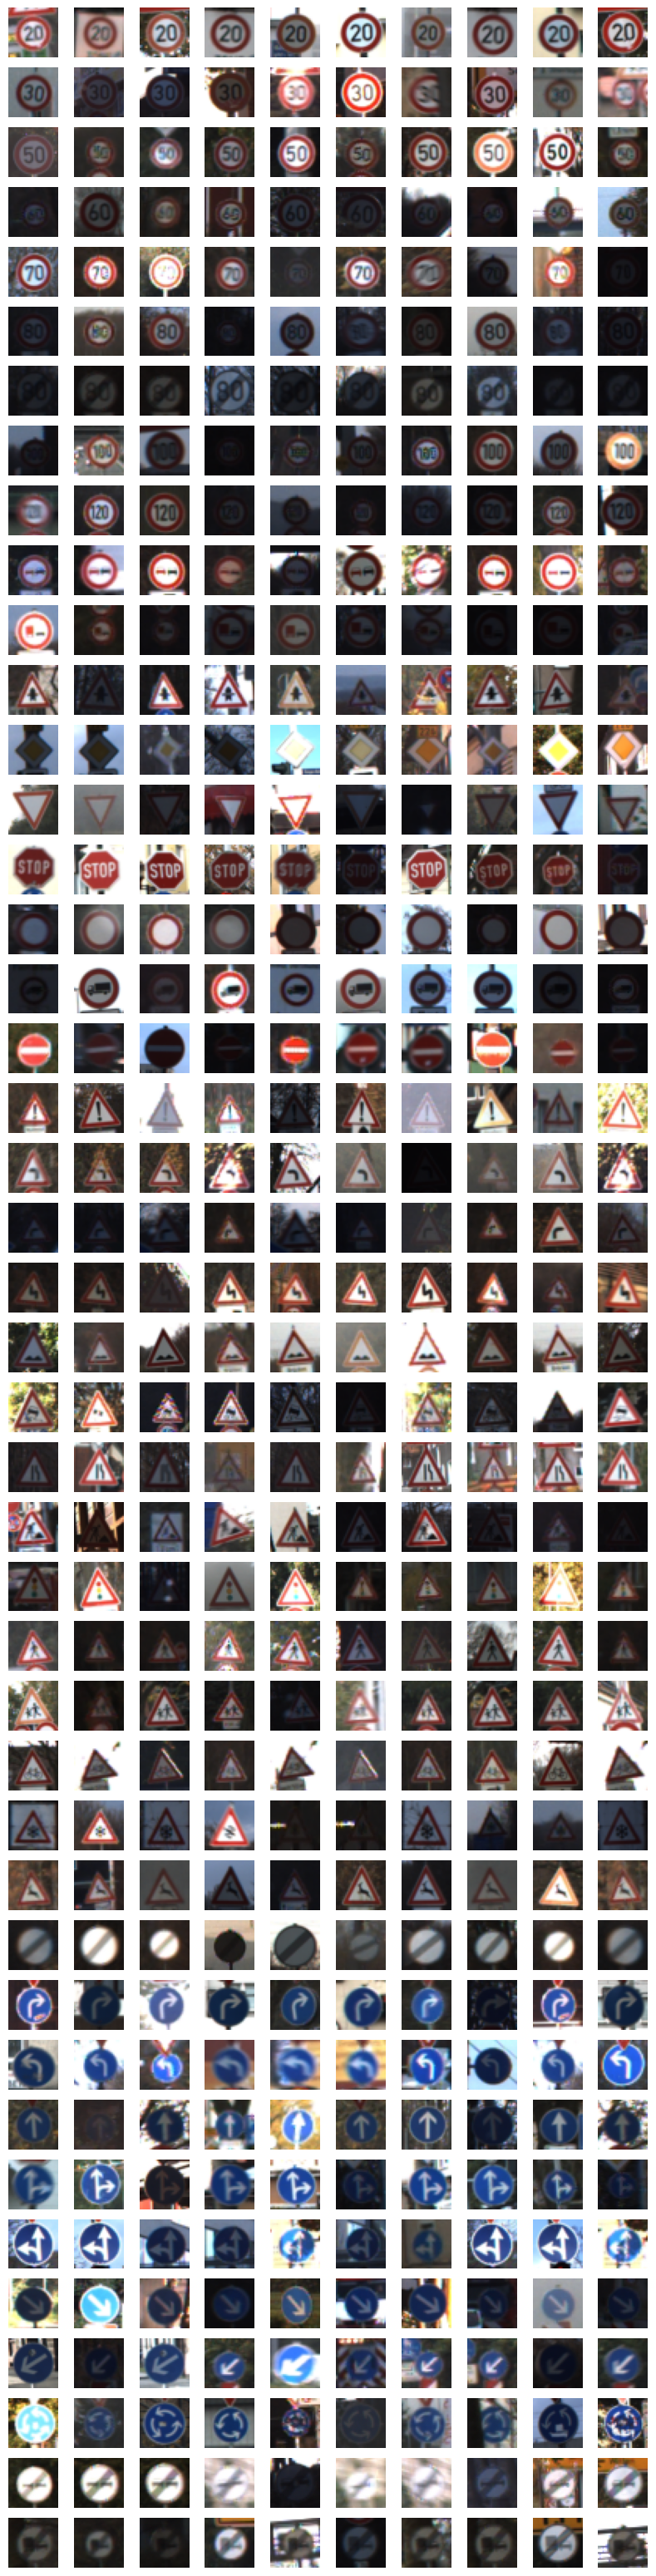

In [ ]:
plt.figure(figsize=(10,40))
count=0
cols = 10
for index in getSamples(cols):
  count+=1
  plt.subplot(classes_n, cols, count)
  plt.imshow(train_x[index])
  plt.axis('off')
plt.savefig('Plots/random_samples.png', bbox_inches = 'tight')

In [ ]:
def makeSharper(img):
  gb = cv2.GaussianBlur(img, (5,5), 20.0)
  return cv2.addWeighted(img, 2, gb,-1, 0)

In [ ]:
def makeTransform(img_in):
  img_in = img_in.copy()
  img_out = makeSharper(img_in)
  img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2YUV)
  img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
  return img_out[:,:,0]

In [ ]:
def scaleImage(img):
  img2 = img.copy()
  sc_y = 0.4*np.random.rand()+1.0
  img2 = cv2.resize(img2, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
  dy = int((img2.shape[1]-img.shape[0])/2)
  end = img.shape[1]-dy
  img2 = img2[dy:end, :,:]
  assert img2.shape[0] == 32
  return img2

In [ ]:
def rotateImage(img):
  c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
  ang = 10.0*np.random.rand()-15
  mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
  return cv2.warpAffine(img, mat, img.shape[:2])

In [ ]:
def makeBinary(img, s=1.0, m = 0.0):
  img2 = cv2.multiply(img, np.array([s]))
  return cv2.add(img2, np.array([m]))

In [ ]:
def changeContrast(img, s=1.0):
  m = 127.0*(1.0-s)
  return makeBinary(img, s, m)

In [ ]:
# Pre-process the Data Set (normalization, grayscale)

def augment_img(img):
  img = img.copy()
  img = changeContrast(img, 1.8*np.random.rand()+0.2)
  img = rotateImage(img)
  img = scaleImage(img)

  return makeTransform(img)


(32, 32)


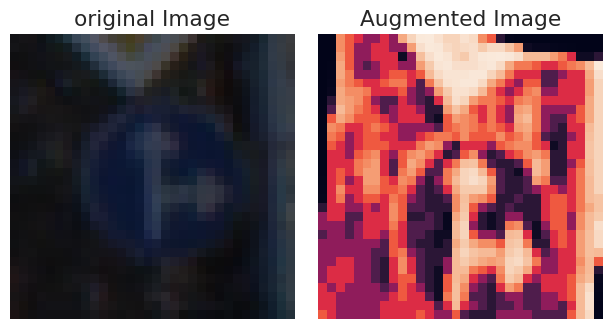

In [ ]:
img = train_x[1000]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
out = augment_img(img)
print(out.shape)
plt.imshow(out)
plt.title('Augmented Image')
plt.tight_layout()
plt.savefig('Plots/augmented_image.png', bbox_inches = 'tight')

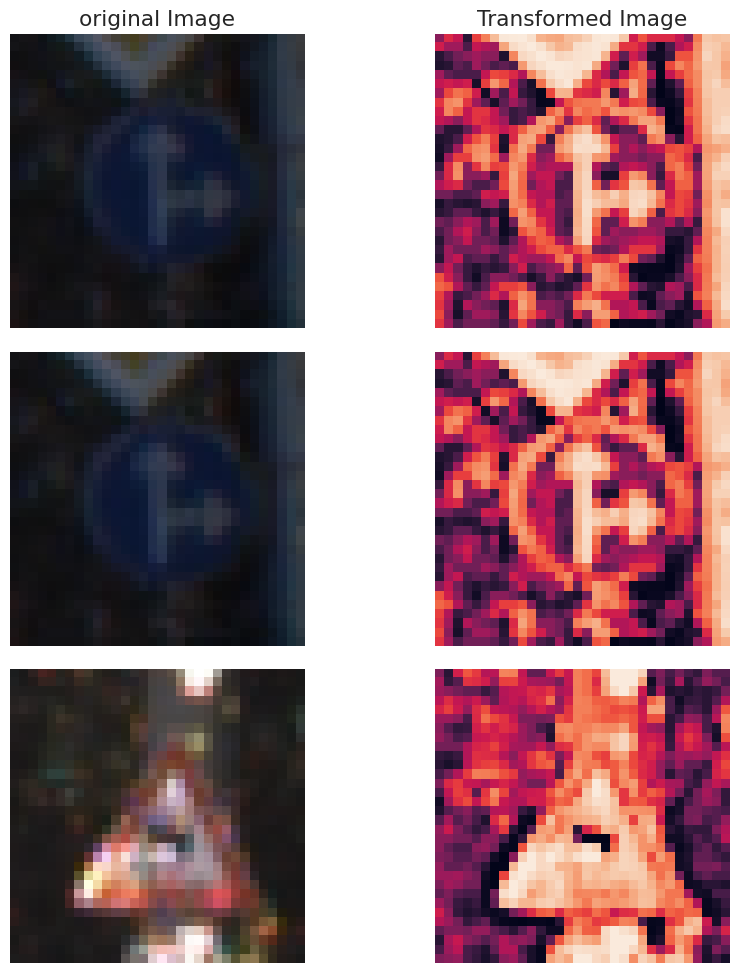

In [ ]:
plt.figure(figsize = (10,10))
img = train_x[1000]
plt.subplot(3,2,1)
plt.imshow(img)
plt.title('original Image')
plt.axis('off')
plt.subplot(3,2,2)
plt.axis('off')
plt.imshow(makeTransform(img))
plt.title('Transformed Image')

img = train_x[1000]
plt.subplot(3,2,3)
plt.imshow(img)
plt.axis('off')
plt.subplot(3,2,4)
plt.axis('off')
plt.imshow(makeTransform(img))

img = train_x[2190]
plt.subplot(3,2,5)
plt.imshow(img)

plt.axis('off')
plt.subplot(3,2,6)
plt.axis('off')
plt.imshow(makeTransform(img))
plt.tight_layout()
plt.savefig('Plots/transformation_images.png', bbox_inches = 'tight')




In [ ]:
# Transform all images and augment training data

train_transform_x = list()
train_transform_y = list()
test_transform_x = list()
valid_transform_x = list()
for index in range(train_x.shape[0]):
  img = train_x[index]
  label = train_y[index]

  imgout = makeTransform(img)
  imgout.shape = (1,) + imgout.shape + (1,)
  train_transform_x.append(imgout)
  train_transform_y.append(label)
  for j in range(10):
    imgout = augment_img(img)
    imgout.shape = (1,) + imgout.shape + (1,)
    train_transform_x.append(imgout)
    train_transform_y.append(label)



In [ ]:
for index in range(valid_x.shape[0]):
  img = valid_x[index]
  img = makeTransform(img)
  img.shape = (1,) + img.shape + (1,)
  valid_transform_x.append(img)

In [ ]:
for index in range(test_x.shape[0]):
  img = test_x[index]
  img = makeTransform(img)
  img.shape = (1,) + img.shape + (1,)
  test_transform_x.append(img)


In [ ]:
test_transform_x = np.concatenate(test_transform_x, axis = 0)
train_transfrom_x = np.concatenate(train_transform_x, axis = 0)
valid_transform_x = np.concatenate(valid_transform_x, axis = 0)
train_transform_y = np.array(train_transform_y)

In [ ]:
def LeNet(x):
  mu = 0
  sigma = 0.1

  conv1_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

  conv1 = tf.nn.relu(conv1)

  conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

  conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

  conv2 = tf.nn.relu(conv2)

  conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

  fc0 = tf.reshape(conv2, [-1, 400])

  fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc1 = tf.matmul(fc0, fc1_w) + fc1_b

  fc1 = tf.nn.relu(fc1)

  dr1 = tf.nn.dropout(fc1, keep_prob)

  fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc2 = tf.matmul(dr1, fc2_w) + fc2_b

  fc2 = tf.nn.relu(fc2)

  dr2 = tf.nn.dropout(fc2, keep_prob)

  fc3_w = tf.Variable(tf.truncated_normal(shape=(84,43), mean = mu, stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(43))
  logits = tf.matmul(dr2, fc3_w) + fc3_b

  return logits


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predicted_proba_operation = tf.nn.softmax(logits=logits)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64)) # Corrected accuracy calculation
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
def evaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
def predict(X_data):
  num_examples = len(X_data)
  sess = tf.get_default_session()
  predicted_proba = list()
  for offset in range(0, num_examples, BATCH_SIZE):
    batch_x = X_data[offset:offset+BATCH_SIZE]
    predicted_proba.extend(sess.run(predicted_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
  return predicted_proba

In [ ]:
print(f"train_x type: {type(train_x)}")
print(f"train_x length: {len(train_x)}")
if len(train_x) > 0:
    print(f"train_x[0] type: {type(train_x[0])}")
    print(f"train_x[0] shape: {np.array(train_x[0]).shape}")

train_x type: <class 'list'>
train_x length: 382789
train_x[0] type: <class 'numpy.ndarray'>
train_x[0] shape: (1, 32, 32, 1)


In [ ]:
import numpy as np

# Convert lists to NumPy arrays and reshape
# train_x = np.array(train_x).reshape(-1, 32, 32, 1) # Remove this line
# valid_x = np.array(valid_x).reshape(-1, 32, 32, 1) # Remove this line
# test_x = np.array(test_x).reshape(-1, 32, 32, 1) # Remove this line

# Also convert labels if they're lists
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

In [ ]:
## Train, Validate and Test the model

train_x = train_transform_x
valid_x = valid_transform_x
test_x = test_transform_x
train_y = train_transform_y
# valid_y and test_y are already assigned from the original pickle load and should align
# with the transformed data if the transformation process didn't change the order or number of samples for valid and test sets.
# Based on the error, it seems the number of samples for valid_x and test_x are not matching valid_y and test_y.
# I will re-run the transformation and assignment for valid and test data in a later cell to ensure consistency.

In [ ]:
def setup_file_logger(log_file):
    # Fixed: FileHandler (capital F), not fileHandler
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    # Fixed: hdlr.setFormatter(), not hdIr = setFormatter()
    hdlr.setFormatter(formatter)

    # Get or create logger
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.addHandler(hdlr)

    return logger

def log(message):
    logger = logging.getLogger()
    logger.info(message)

In [ ]:
def log(message):
  print('{} {}'.format(datetime.datetime.now(), message))
  logger.info(message)

In [ ]:
# Add this right before your training loop to debug shapes
with tf.compat.v1.Session() as debug_sess:
    debug_sess.run(tf.compat.v1.global_variables_initializer())
    sample_batch_x = train_x[:10]
    sample_batch_y = train_y[:10]

    print(f"Sample batch_x shape: {sample_batch_x.shape}")
    print(f"Sample batch_y shape: {sample_batch_y.shape}")
    print(f"Sample batch_y content: {sample_batch_y[:5]}")


Sample batch_x shape: (10, 32, 32, 1)
Sample batch_y shape: (10,)
Sample batch_y content: [13 23 33 18 11]


In [ ]:
with tf.compat.v1.Session() as debug_sess:
    debug_sess.run(tf.compat.v1.global_variables_initializer())
    sample_batch_x = train_x[:10]
    sample_batch_y = train_y[:10]
    logits_val = debug_sess.run(logits, feed_dict={x: sample_batch_x, keep_prob: 1.0})
    print(f"Logits shape: {logits_val.shape}")

Logits shape: (10, 43)


In [ ]:
with tf.compat.v1.Session() as debug_sess:
    debug_sess.run(tf.compat.v1.global_variables_initializer())
    sample_batch_x = train_x[:10]
    sample_batch_y = train_y[:10]
    pred_argmax = debug_sess.run(tf.argmax(logits, 1), feed_dict={x: sample_batch_x, keep_prob: 1.0})
    print(f"Predicted argmax shape: {pred_argmax.shape}")
    print(f"Predicted argmax content: {pred_argmax[:5]}")

Predicted argmax shape: (10,)
Predicted argmax content: [19 19 19 19 19]


In [ ]:
# For integer labels
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
#Your training loop (with the fix)
setup_file_logger('training.log')
EPOCHS = 150
BATCH_SIZE = 128
dropout = 0.3
learning_rate = 0.001
errors = list()
saver = tf.compat.v1.train.Saver()
start = time()

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(train_x)
    log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, learning_rate))

    for i in range(EPOCHS):
        try:
            train_x, train_y = shuffle(train_x, train_y)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = train_x[offset:end], train_y[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})

            validation_accuracy = evaluate(valid_x, valid_y, sess)
            training_accuracy = evaluate(train_x, train_y, sess)
            errors.append((training_accuracy, validation_accuracy))

            log("EPOCH %d - %d sec ..."%(i+1, time() - start))
            log("Training accuracy = {:.3f} Validation accuracy = {:.3f}".format(training_accuracy, validation_accuracy))

            if i > 5 and i % 3 == 0:
                saver.save(sess, 'models/lenet')
                print("Model saved %d sec"%(time() - start))

        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate(test_x, test_y, sess)))
            break

    saver.save(sess, 'models/lenet')

In [ ]:
plt.figure(figsize=(8,6))
plt.title('learining Curve')
plt.plot([1 - el[0] for el in errors])
plt.plot([1 - el[1] for el in errors])
plt,ylim([-.01,0.35])
plt.legend(['Training Error', 'Validation Error'])
plt.tight_layout()
plt.savefig('plots/learning_curve.png')
plt.ylabel('Error')
plt.xlabel('Epoch')

In [ ]:
with tf.Session() as sess:
  saver.restore(sess, tf.train.latest_checkpoint('models'))
  print('Accuracy Model On Training Images: {:.2f}'.format(evaluate(train_x, train_y)))
  print('Accuracy Model On Validation Images: {:.2f}'.format(evaluate(valid_x, valid_y)))
  print('Accuracy Model On Test Images: {:.2f}'.format(evaluate(test_x, test_y)))


In [ ]:
# Testing the Models with new found images
# Create a folder call more_images, add to the folder 7 new images and a notepad contains image labels

import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian
import glob



In [ ]:
i = 1
plt.figure(figsize=(12,10))
for el in glob.glob('more_images/*.png') + glob.glob('more_images/*.jpg'):
  print(el)
  img = io.imread(el)
  plt.subplot(1,6,i)
  plt.imshow(img)
  i+=1
  plt.axis('off')
  img = transform.resize(img, (32,32), order=3)
  img = gaussian(img,.4,multichannel=True)

In [ ]:
plt,savefig('plots/more_images.png', bbox_inches = 'tight')

In [ ]:
i = 1
images_wild = list()
labels_wild = list()
for line in open('more_images/data.txt', 'r'):
  fname, label = line.strip().split('')
  label = int(label)
  fname = 'more_images/'+fname
  img = io.imread(fname)
  img = transform.resize(img,(32,32), order=3)
  img = guassian(img,.6, multichannel=True)*255
  img = transform_img(img.astype(np.uint8))
  img.shape = (1,) + img.shape + (1,)
  images_wild.append(img)
  labels_wild.append(label)

In [ ]:
images = np.concatenate(images_wild, axis=0)


In [ ]:
with tf.Session() as sess:
  saver.restore(sess, tf.train.latest_checkpoint('models'))
  predicted_proba = np.vstack(predict(images))
  print('Accuracy Model on new Images: {}'.format(evaluate(images, labels_wild)))


In [ ]:
# Getting Top 5 Softmax Probabilities for each new images

for true_label,row in zip(labels_wild,predicted_proba):
  top5k = np.argsort(row)[::-1][:5]
  top5p = np.sort(row)[::-1][:5]
  print('Top 5 Labels for image \'{}\':'.format(get_name_from_label(true_label)))
  for k,p in zip(top5k,top5p):
    print(' - \'{}\' with prob = {:.2f}'.format(get_name_from_label(k),p))


In [ ]:
def setup_file_logger(log_file):
  hdIr = logging.FileHandler(log_file)
  formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
  hdIr.setFormatter(formatter)
  logger.addHandler(hdIr)
  logger.setLevel(logging.INFO)

In [ ]:
setup_file_logger('training.log')

EPOCHS = 150
BATCH_SIZE = 128
dropout = .3
errors = list()

saver = tf.train.Saver()
start = time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  num_examples = len(train_x)
  log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
  print()
  for i in range(EPOCHS):
    try:
      train_x, train_y = shuffle(train_x, train_y)
      for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = train_x[offset:end], train_y[offset:end]
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})
        validation_accuracy = evaluate(valid_x, valid_y)
        trainig_accuarcy = evaluate(train_x, train_y)
        errors.append((training_accuracy, validation_accuracy))
        log("EPOCH %d - %d sec ..."%(i+1, time() - start))
        log("Training error = {:.3f} Validation error = {:.3f}".format(1-training_accuracy, 1-validation_accuracy))
        print()
        if i > 5 and i % 3 == 0:
          saver.save(sess, 'models/lenet')
          print("Model saved %d sec"%(time() - start))
    except keyboardInterrupt:
        print('Accuracy Model On Test Images: {}'.format(evaluate(test_x, test_y)))
        break
    saver.save(sess, 'models/lenet')

# create an empty folder call Models and change run time to GPU

In [ ]:
setup_file_logger('training.log')

EPOCHS = 150
BATCH_SIZE = 128
dropout = .3
errors = list()

start = time()
log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
print()

# Convert labels to one-hot encoding
train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=classes_n)
valid_y_one_hot = tf.keras.utils.to_categorical(valid_y, num_classes=classes_n)
# test_y_one_hot = tf.keras.utils.to_categorical(test_y, num_classes=classes_n) # Not needed for evaluation

for i in range(EPOCHS):
    try:
        train_x, train_y_one_hot = shuffle(train_x, train_y_one_hot)
        # Use model.fit for training
        history = model.fit(train_x, train_y_one_hot,
                            batch_size=BATCH_SIZE,
                            epochs=1, # Train for one epoch at a time
                            verbose=0,
                            validation_data=(valid_x, valid_y_one_hot))

        training_accuracy = history.history['accuracy'][0]
        validation_accuracy = history.history['val_accuracy'][0]
        errors.append((training_accuracy, validation_accuracy))

        log("EPOCH %d - %d sec ..."%(i+1, time() - start))
        log("Training error = {:.3f} Validation error = {:.3f}".format(1-training_accuracy, 1-validation_accuracy))
        print()

        if i > 5 and i % 3 == 0:
            model.save('models/lenet_model')
            print("Model saved %d sec"%(time() - start))

    except KeyboardInterrupt: # Corrected exception name
        print('Accuracy Model On Test Images: {}'.format(model.evaluate(test_x, tf.keras.utils.to_categorical(test_y, num_classes=classes_n), verbose=0)[1]))
        break

model.save('models/lenet_model') # Save model after training

In [ ]:
# Reconstruct train_transform_x and train_transform_y to ensure matching cardinality

train_transform_x = []
train_transform_y = []

for index in range(train_x.shape[0]):
  img = train_x[index]
  label = train_y[index]

  # Add original transformed image
  imgout = makeTransform(img)
  imgout = np.expand_dims(imgout, axis=-1) # Add channel dimension
  train_transform_x.append(imgout)
  train_transform_y.append(label)

  # Add augmented images
  for j in range(10):
    imgout_aug = augment_img(img)
    imgout_aug = np.expand_dims(imgout_aug, axis=-1) # Add channel dimension
    train_transform_x.append(imgout_aug)
    train_transform_y.append(label)

# Concatenate the lists into numpy arrays
train_transform_x = np.array(train_transform_x)
train_transform_y = np.array(train_transform_y)

# Process validation and test sets similarly
valid_transform_x = []
for index in range(valid_x.shape[0]):
  img = valid_x[index]
  img = makeTransform(img)
  img = np.expand_dims(img, axis=-1)
  valid_transform_x.append(img)
valid_transform_x = np.array(valid_transform_x)

test_transform_x = []
for index in range(test_x.shape[0]):
  img = test_x[index]
  img = makeTransform(img)
  img = np.expand_dims(img, axis=-1)
  test_transform_x.append(img)
test_transform_x = np.array(test_transform_x)


# Update train_x, valid_x, and test_x to use the transformed data
train_x = train_transform_x
valid_x = valid_transform_x
test_x = test_transform_x

# Convert labels to one-hot encoding after ensuring cardinality matches
train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=classes_n)
valid_y_one_hot = tf.keras.utils.to_categorical(valid_y, num_classes=classes_n)


# Redefine evaluate and predict functions using Keras model methods
def evaluate_keras(X_data, y_data):
    # Ensure y_data is one-hot encoded for evaluation
    y_data_one_hot = tf.keras.utils.to_categorical(y_data, num_classes=classes_n)
    loss, accuracy = model.evaluate(X_data, y_data_one_hot, verbose=0)
    return accuracy

def predict_keras(X_data):
    predictions = model.predict(X_data)
    return predictions

# Training loop using model.fit
setup_file_logger('training.log')

EPOCHS = 150
BATCH_SIZE = 128
dropout = .3
errors = list()

start = time()
log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
print()

for i in range(EPOCHS):
    try:
        train_x_shuffled, train_y_one_hot_shuffled = shuffle(train_x, train_y_one_hot)
        # Use model.fit for training
        history = model.fit(train_x_shuffled, train_y_one_hot_shuffled,
                            batch_size=BATCH_SIZE,
                            epochs=1, # Train for one epoch at a time
                            verbose=0,
                            validation_data=(valid_x, valid_y_one_hot))

        training_accuracy = history.history['accuracy'][0]
        validation_accuracy = history.history['val_accuracy'][0]
        errors.append((training_accuracy, validation_accuracy))

        log("EPOCH %d - %d sec ..."%(i+1, time() - start))
        log("Training error = {:.3f} Validation error = {:.3f}".format(1-training_accuracy, 1-validation_accuracy))
        print()

        if i > 5 and i % 3 == 0:
            model.save('models/lenet_model')
            print("Model saved %d sec"%(time() - start))

    except KeyboardInterrupt:
        print('Accuracy Model On Test Images: {:.2f}'.format(evaluate_keras(test_x, test_y)))
        break

model.save('models/lenet_model') # Save model after training

In [ ]:
# Reconstruct train_transform_x and train_transform_y to ensure matching cardinality

train_transform_x_list = []
train_transform_y_list = []

# Use the original train_x and train_y from pickle loading
# These should be NumPy arrays from the initial data loading cells (6SxNVTvt8jOS)
# Check their types and shapes if necessary before proceeding.

for index in range(train['features'].shape[0]):
  img = train['features'][index]
  label = train['labels'][index]

  # Add original transformed image
  imgout = makeTransform(img)
  imgout = np.expand_dims(imgout, axis=-1) # Add channel dimension
  train_transform_x_list.append(imgout)
  train_transform_y_list.append(label)

  # Add augmented images
  for j in range(10):
    imgout_aug = augment_img(img)
    imgout_aug = np.expand_dims(imgout_aug, axis=-1) # Add channel dimension
    train_transform_x_list.append(imgout_aug)
    train_transform_y_list.append(label)

# Concatenate the lists into numpy arrays
train_x = np.array(train_transform_x_list)
train_y = np.array(train_transform_y_list)

# Process validation and test sets similarly
valid_transform_x_list = []
valid_transform_y_list = [] # Create a list for valid_y as well
for index in range(valid['features'].shape[0]):
  img = valid['features'][index]
  label = valid['labels'][index] # Get the corresponding label
  img = makeTransform(img)
  img = np.expand_dims(img, axis=-1)
  valid_transform_x_list.append(img)
  valid_transform_y_list.append(label) # Append the label
valid_x = np.array(valid_transform_x_list)
valid_y = np.array(valid_transform_y_list) # Convert valid_y_list to numpy array

test_transform_x_list = []
test_transform_y_list = [] # Create a list for test_y as well
for index in range(test['features'].shape[0]):
  img = test['features'][index]
  label = test['labels'][index] # Get the corresponding label
  img = makeTransform(img)
  img = np.expand_dims(img, axis=-1)
  test_transform_x_list.append(img)
  test_transform_y_list.append(label) # Append the label
test_x = np.array(test_transform_x_list)
test_y = np.array(test_transform_y_list) # Convert test_y_list to numpy array


# Verify shapes after concatenation
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of valid_x:", valid_x.shape)
print("Shape of valid_y:", valid_y.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of test_y:", test_y.shape)


# Convert labels to one-hot encoding after ensuring cardinality matches
# train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=classes_n) # Not needed for this TensorFlow 1.x approach
# valid_y_one_hot = tf.keras.utils.to_categorical(valid_y, num_classes=classes_n) # Not needed for this TensorFlow 1.x approach


# Redefine evaluate and predict functions using the TensorFlow 1.x session
def evaluate_tf1(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def predict_tf1(X_data, sess):
  num_examples = len(X_data)
  predicted_proba = list()
  for offset in range(0, num_examples, BATCH_SIZE):
    batch_x = X_data[offset:offset+BATCH_SIZE]
    predicted_proba.extend(sess.run(predicted_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
  return predicted_proba


# Training loop using TensorFlow 1.x session
setup_file_logger('training.log')

EPOCHS = 150
BATCH_SIZE = 128
dropout = .3
errors = list()

saver = tf.compat.v1.train.Saver()
start = time()
log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
print()

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(train_x)


    for i in range(EPOCHS):
        try:
            train_x, train_y = shuffle(train_x, train_y)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = train_x[offset:end], train_y[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})

            # Add print statements to check shapes before evaluation
            print(f"Shape of train_x before evaluation: {train_x.shape}")
            print(f"Shape of train_y before evaluation: {train_y.shape}")
            print(f"Shape of valid_x before evaluation: {valid_x.shape}")
            print(f"Shape of valid_y before evaluation: {valid_y.shape}")
            print(f"Shape of test_x before evaluation: {test_x.shape}")
            print(f"Shape of test_y before evaluation: {test_y.shape}")


            validation_accuracy = evaluate_tf1(valid_x, valid_y, sess) # Use evaluate_tf1
            training_accuracy = evaluate_tf1(train_x, train_y, sess) # Use evaluate_tf1
            errors.append((training_accuracy, validation_accuracy))

            log("EPOCH %d - %d sec ..."%(i+1, time() - start))
            log("Training accuracy = {:.3f} Validation accuracy = {:.3f}".format(training_accuracy, validation_accuracy))

            if i > 5 and i % 3 == 0:
                saver.save(sess, 'models/lenet')
                print("Model saved %d sec"%(time() - start))

        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate_tf1(test_x, test_y, sess))) # Use evaluate_tf1
            break
    saver.save(sess, 'models/lenet')

# create an empty folder call Models and change run time to GPU

INFO:root:Training... dropout = 0.3 , batch_size = 128 , learning rate = 0.001


Shape of train_x: (382789, 32, 32, 1)
Shape of train_y: (382789,)
Shape of valid_x: (4410, 32, 32, 1)
Shape of valid_y: (4410,)
Shape of test_x: (12630, 32, 32, 1)
Shape of test_y: (12630,)
2025-07-07 04:42:19.790993 Training... dropout = 0.3 , batch_size = 128 , learning rate = 0.001

Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 1 - 15 sec ...
INFO:root:Training accuracy = 0.775 Validation accuracy = 0.723


2025-07-07 04:42:35.091836 EPOCH 1 - 15 sec ...
2025-07-07 04:42:35.093177 Training accuracy = 0.775 Validation accuracy = 0.723
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 2 - 29 sec ...
INFO:root:Training accuracy = 0.855 Validation accuracy = 0.821


2025-07-07 04:42:49.595715 EPOCH 2 - 29 sec ...
2025-07-07 04:42:49.597524 Training accuracy = 0.855 Validation accuracy = 0.821
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 3 - 44 sec ...
INFO:root:Training accuracy = 0.882 Validation accuracy = 0.872


2025-07-07 04:43:04.361761 EPOCH 3 - 44 sec ...
2025-07-07 04:43:04.363126 Training accuracy = 0.882 Validation accuracy = 0.872
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 4 - 58 sec ...
INFO:root:Training accuracy = 0.893 Validation accuracy = 0.902


2025-07-07 04:43:18.298985 EPOCH 4 - 58 sec ...
2025-07-07 04:43:18.300689 Training accuracy = 0.893 Validation accuracy = 0.902
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 5 - 72 sec ...
INFO:root:Training accuracy = 0.899 Validation accuracy = 0.891


2025-07-07 04:43:32.067596 EPOCH 5 - 72 sec ...
2025-07-07 04:43:32.069575 Training accuracy = 0.899 Validation accuracy = 0.891
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 6 - 86 sec ...
INFO:root:Training accuracy = 0.903 Validation accuracy = 0.907


2025-07-07 04:43:46.521833 EPOCH 6 - 86 sec ...
2025-07-07 04:43:46.525958 Training accuracy = 0.903 Validation accuracy = 0.907
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 7 - 101 sec ...
INFO:root:Training accuracy = 0.903 Validation accuracy = 0.907


2025-07-07 04:44:01.448464 EPOCH 7 - 101 sec ...
2025-07-07 04:44:01.452131 Training accuracy = 0.903 Validation accuracy = 0.907
Model saved 101 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 8 - 115 sec ...
INFO:root:Training accuracy = 0.903 Validation accuracy = 0.897


2025-07-07 04:44:15.461742 EPOCH 8 - 115 sec ...
2025-07-07 04:44:15.463965 Training accuracy = 0.903 Validation accuracy = 0.897
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 9 - 129 sec ...
INFO:root:Training accuracy = 0.908 Validation accuracy = 0.914


2025-07-07 04:44:29.345777 EPOCH 9 - 129 sec ...
2025-07-07 04:44:29.347542 Training accuracy = 0.908 Validation accuracy = 0.914
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 10 - 143 sec ...
INFO:root:Training accuracy = 0.913 Validation accuracy = 0.921


2025-07-07 04:44:43.685007 EPOCH 10 - 143 sec ...
2025-07-07 04:44:43.686507 Training accuracy = 0.913 Validation accuracy = 0.921
Model saved 143 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 11 - 158 sec ...
INFO:root:Training accuracy = 0.914 Validation accuracy = 0.916


2025-07-07 04:44:57.934312 EPOCH 11 - 158 sec ...
2025-07-07 04:44:57.937440 Training accuracy = 0.914 Validation accuracy = 0.916
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 12 - 172 sec ...
INFO:root:Training accuracy = 0.914 Validation accuracy = 0.918


2025-07-07 04:45:12.249801 EPOCH 12 - 172 sec ...
2025-07-07 04:45:12.251358 Training accuracy = 0.914 Validation accuracy = 0.918
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 13 - 186 sec ...
INFO:root:Training accuracy = 0.911 Validation accuracy = 0.915


2025-07-07 04:45:26.722724 EPOCH 13 - 186 sec ...
2025-07-07 04:45:26.723986 Training accuracy = 0.911 Validation accuracy = 0.915
Model saved 186 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 14 - 201 sec ...
INFO:root:Training accuracy = 0.907 Validation accuracy = 0.907


2025-07-07 04:45:40.891985 EPOCH 14 - 201 sec ...
2025-07-07 04:45:40.894315 Training accuracy = 0.907 Validation accuracy = 0.907
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 15 - 215 sec ...
INFO:root:Training accuracy = 0.913 Validation accuracy = 0.916


2025-07-07 04:45:54.791363 EPOCH 15 - 215 sec ...
2025-07-07 04:45:54.793720 Training accuracy = 0.913 Validation accuracy = 0.916
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 16 - 228 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.927


2025-07-07 04:46:08.761814 EPOCH 16 - 228 sec ...
2025-07-07 04:46:08.763386 Training accuracy = 0.917 Validation accuracy = 0.927
Model saved 229 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 17 - 244 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.927


2025-07-07 04:46:24.490145 EPOCH 17 - 244 sec ...
2025-07-07 04:46:24.492487 Training accuracy = 0.917 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 18 - 258 sec ...
INFO:root:Training accuracy = 0.916 Validation accuracy = 0.916


2025-07-07 04:46:38.087103 EPOCH 18 - 258 sec ...
2025-07-07 04:46:38.088568 Training accuracy = 0.916 Validation accuracy = 0.916
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 19 - 272 sec ...
INFO:root:Training accuracy = 0.911 Validation accuracy = 0.909


2025-07-07 04:46:51.958501 EPOCH 19 - 272 sec ...
2025-07-07 04:46:51.960516 Training accuracy = 0.911 Validation accuracy = 0.909
Model saved 272 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 20 - 286 sec ...
INFO:root:Training accuracy = 0.914 Validation accuracy = 0.909


2025-07-07 04:47:06.279390 EPOCH 20 - 286 sec ...
2025-07-07 04:47:06.280991 Training accuracy = 0.914 Validation accuracy = 0.909
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 21 - 300 sec ...
INFO:root:Training accuracy = 0.915 Validation accuracy = 0.925


2025-07-07 04:47:20.028940 EPOCH 21 - 300 sec ...
2025-07-07 04:47:20.030492 Training accuracy = 0.915 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 22 - 314 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.916


2025-07-07 04:47:34.054878 EPOCH 22 - 314 sec ...
2025-07-07 04:47:34.056843 Training accuracy = 0.919 Validation accuracy = 0.916
Model saved 314 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 23 - 328 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.922


2025-07-07 04:47:48.000004 EPOCH 23 - 328 sec ...
2025-07-07 04:47:48.001638 Training accuracy = 0.917 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 24 - 341 sec ...
INFO:root:Training accuracy = 0.909 Validation accuracy = 0.902


2025-07-07 04:48:01.639715 EPOCH 24 - 341 sec ...
2025-07-07 04:48:01.641960 Training accuracy = 0.909 Validation accuracy = 0.902
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 25 - 355 sec ...
INFO:root:Training accuracy = 0.909 Validation accuracy = 0.913


2025-07-07 04:48:15.538222 EPOCH 25 - 355 sec ...
2025-07-07 04:48:15.539783 Training accuracy = 0.909 Validation accuracy = 0.913
Model saved 355 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 26 - 369 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.922


2025-07-07 04:48:29.703208 EPOCH 26 - 369 sec ...
2025-07-07 04:48:29.705074 Training accuracy = 0.921 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 27 - 386 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.921


2025-07-07 04:48:46.658744 EPOCH 27 - 386 sec ...
2025-07-07 04:48:46.660329 Training accuracy = 0.919 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 28 - 403 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.922


2025-07-07 04:49:03.686313 EPOCH 28 - 403 sec ...
2025-07-07 04:49:03.687667 Training accuracy = 0.917 Validation accuracy = 0.922
Model saved 403 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 29 - 418 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.929


2025-07-07 04:49:18.426711 EPOCH 29 - 418 sec ...
2025-07-07 04:49:18.430554 Training accuracy = 0.925 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 30 - 438 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.921


2025-07-07 04:49:38.020348 EPOCH 30 - 438 sec ...
2025-07-07 04:49:38.034421 Training accuracy = 0.921 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 31 - 454 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.926


2025-07-07 04:49:53.966095 EPOCH 31 - 454 sec ...
2025-07-07 04:49:53.970186 Training accuracy = 0.925 Validation accuracy = 0.926
Model saved 454 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 32 - 468 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.921


2025-07-07 04:50:07.856230 EPOCH 32 - 468 sec ...
2025-07-07 04:50:07.858585 Training accuracy = 0.921 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 33 - 480 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.923


2025-07-07 04:50:20.745561 EPOCH 33 - 480 sec ...
2025-07-07 04:50:20.749185 Training accuracy = 0.921 Validation accuracy = 0.923
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 34 - 493 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.913


2025-07-07 04:50:33.419871 EPOCH 34 - 493 sec ...
2025-07-07 04:50:33.424682 Training accuracy = 0.919 Validation accuracy = 0.913
Model saved 493 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 35 - 506 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.925


2025-07-07 04:50:46.010138 EPOCH 35 - 506 sec ...
2025-07-07 04:50:46.014220 Training accuracy = 0.919 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 36 - 518 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.929


2025-07-07 04:50:58.407698 EPOCH 36 - 518 sec ...
2025-07-07 04:50:58.412099 Training accuracy = 0.923 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 37 - 531 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.922


2025-07-07 04:51:10.842280 EPOCH 37 - 531 sec ...
2025-07-07 04:51:10.844097 Training accuracy = 0.924 Validation accuracy = 0.922
Model saved 531 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 38 - 543 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.920


2025-07-07 04:51:23.480174 EPOCH 38 - 543 sec ...
2025-07-07 04:51:23.486045 Training accuracy = 0.924 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 39 - 556 sec ...
INFO:root:Training accuracy = 0.916 Validation accuracy = 0.912


2025-07-07 04:51:36.051097 EPOCH 39 - 556 sec ...
2025-07-07 04:51:36.052663 Training accuracy = 0.916 Validation accuracy = 0.912
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 40 - 568 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.925


2025-07-07 04:51:48.663211 EPOCH 40 - 568 sec ...
2025-07-07 04:51:48.665243 Training accuracy = 0.921 Validation accuracy = 0.925
Model saved 568 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 41 - 581 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.920


2025-07-07 04:52:01.534948 EPOCH 41 - 581 sec ...
2025-07-07 04:52:01.536315 Training accuracy = 0.919 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 42 - 594 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.925


2025-07-07 04:52:14.472053 EPOCH 42 - 594 sec ...
2025-07-07 04:52:14.473591 Training accuracy = 0.925 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 43 - 607 sec ...
INFO:root:Training accuracy = 0.914 Validation accuracy = 0.923


2025-07-07 04:52:27.345636 EPOCH 43 - 607 sec ...
2025-07-07 04:52:27.347798 Training accuracy = 0.914 Validation accuracy = 0.923
Model saved 607 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 44 - 620 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.922


2025-07-07 04:52:40.410010 EPOCH 44 - 620 sec ...
2025-07-07 04:52:40.412880 Training accuracy = 0.921 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 45 - 633 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.921


2025-07-07 04:52:53.364807 EPOCH 45 - 633 sec ...
2025-07-07 04:52:53.366528 Training accuracy = 0.923 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 46 - 646 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.918


2025-07-07 04:53:06.416158 EPOCH 46 - 646 sec ...
2025-07-07 04:53:06.418085 Training accuracy = 0.920 Validation accuracy = 0.918
Model saved 646 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 47 - 660 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.929


2025-07-07 04:53:20.457268 EPOCH 47 - 660 sec ...
2025-07-07 04:53:20.458513 Training accuracy = 0.923 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 48 - 673 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.920


2025-07-07 04:53:33.095673 EPOCH 48 - 673 sec ...
2025-07-07 04:53:33.097033 Training accuracy = 0.920 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 49 - 685 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.923


2025-07-07 04:53:45.728245 EPOCH 49 - 685 sec ...
2025-07-07 04:53:45.729626 Training accuracy = 0.923 Validation accuracy = 0.923
Model saved 685 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 50 - 698 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.927


2025-07-07 04:53:58.420280 EPOCH 50 - 698 sec ...
2025-07-07 04:53:58.424271 Training accuracy = 0.925 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 51 - 711 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.931


2025-07-07 04:54:11.071121 EPOCH 51 - 711 sec ...
2025-07-07 04:54:11.074315 Training accuracy = 0.924 Validation accuracy = 0.931
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 52 - 723 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.915


2025-07-07 04:54:23.744194 EPOCH 52 - 723 sec ...
2025-07-07 04:54:23.745752 Training accuracy = 0.917 Validation accuracy = 0.915
Model saved 724 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 53 - 736 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.923


2025-07-07 04:54:36.492073 EPOCH 53 - 736 sec ...
2025-07-07 04:54:36.494009 Training accuracy = 0.923 Validation accuracy = 0.923
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 54 - 749 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.931


2025-07-07 04:54:49.072533 EPOCH 54 - 749 sec ...
2025-07-07 04:54:49.074139 Training accuracy = 0.923 Validation accuracy = 0.931
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 55 - 761 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.920


2025-07-07 04:55:01.673568 EPOCH 55 - 761 sec ...
2025-07-07 04:55:01.676375 Training accuracy = 0.924 Validation accuracy = 0.920
Model saved 761 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 56 - 774 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.921


2025-07-07 04:55:14.242704 EPOCH 56 - 774 sec ...
2025-07-07 04:55:14.245689 Training accuracy = 0.921 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 57 - 787 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.921


2025-07-07 04:55:26.823656 EPOCH 57 - 787 sec ...
2025-07-07 04:55:26.825027 Training accuracy = 0.925 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 58 - 799 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.921


2025-07-07 04:55:39.454134 EPOCH 58 - 799 sec ...
2025-07-07 04:55:39.455931 Training accuracy = 0.923 Validation accuracy = 0.921
Model saved 799 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 59 - 812 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.925


2025-07-07 04:55:52.357281 EPOCH 59 - 812 sec ...
2025-07-07 04:55:52.360729 Training accuracy = 0.920 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 60 - 825 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.927


2025-07-07 04:56:05.001483 EPOCH 60 - 825 sec ...
2025-07-07 04:56:05.002686 Training accuracy = 0.925 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 61 - 837 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.920


2025-07-07 04:56:17.670546 EPOCH 61 - 837 sec ...
2025-07-07 04:56:17.672126 Training accuracy = 0.921 Validation accuracy = 0.920
Model saved 837 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 62 - 850 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.932


2025-07-07 04:56:30.464909 EPOCH 62 - 850 sec ...
2025-07-07 04:56:30.466535 Training accuracy = 0.925 Validation accuracy = 0.932
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 63 - 864 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.920


2025-07-07 04:56:44.079212 EPOCH 63 - 864 sec ...
2025-07-07 04:56:44.080800 Training accuracy = 0.920 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 64 - 876 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.934


2025-07-07 04:56:56.658069 EPOCH 64 - 876 sec ...
2025-07-07 04:56:56.659866 Training accuracy = 0.925 Validation accuracy = 0.934
Model saved 876 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 65 - 889 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.935


2025-07-07 04:57:09.393254 EPOCH 65 - 889 sec ...
2025-07-07 04:57:09.394813 Training accuracy = 0.926 Validation accuracy = 0.935
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 66 - 902 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.927


2025-07-07 04:57:22.045085 EPOCH 66 - 902 sec ...
2025-07-07 04:57:22.050020 Training accuracy = 0.925 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 67 - 914 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.932


2025-07-07 04:57:34.668078 EPOCH 67 - 914 sec ...
2025-07-07 04:57:34.672038 Training accuracy = 0.924 Validation accuracy = 0.932
Model saved 914 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 68 - 927 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.921


2025-07-07 04:57:47.194262 EPOCH 68 - 927 sec ...
2025-07-07 04:57:47.195630 Training accuracy = 0.919 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 69 - 939 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.925


2025-07-07 04:57:59.573373 EPOCH 69 - 939 sec ...
2025-07-07 04:57:59.575873 Training accuracy = 0.925 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 70 - 952 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.913


2025-07-07 04:58:11.999600 EPOCH 70 - 952 sec ...
2025-07-07 04:58:12.003996 Training accuracy = 0.917 Validation accuracy = 0.913
Model saved 952 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 71 - 964 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.928


2025-07-07 04:58:24.718376 EPOCH 71 - 964 sec ...
2025-07-07 04:58:24.720052 Training accuracy = 0.926 Validation accuracy = 0.928
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 72 - 977 sec ...
INFO:root:Training accuracy = 0.922 Validation accuracy = 0.933


2025-07-07 04:58:37.489396 EPOCH 72 - 977 sec ...
2025-07-07 04:58:37.491255 Training accuracy = 0.922 Validation accuracy = 0.933
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 73 - 990 sec ...
INFO:root:Training accuracy = 0.872 Validation accuracy = 0.871


2025-07-07 04:58:50.096152 EPOCH 73 - 990 sec ...
2025-07-07 04:58:50.098896 Training accuracy = 0.872 Validation accuracy = 0.871
Model saved 990 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 74 - 1003 sec ...
INFO:root:Training accuracy = 0.919 Validation accuracy = 0.922


2025-07-07 04:59:03.032088 EPOCH 74 - 1003 sec ...
2025-07-07 04:59:03.033766 Training accuracy = 0.919 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 75 - 1016 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.924


2025-07-07 04:59:15.830065 EPOCH 75 - 1016 sec ...
2025-07-07 04:59:15.832999 Training accuracy = 0.924 Validation accuracy = 0.924
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 76 - 1028 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.931


2025-07-07 04:59:28.624963 EPOCH 76 - 1028 sec ...
2025-07-07 04:59:28.626801 Training accuracy = 0.926 Validation accuracy = 0.931
Model saved 1028 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 77 - 1041 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.925


2025-07-07 04:59:41.204952 EPOCH 77 - 1041 sec ...
2025-07-07 04:59:41.206272 Training accuracy = 0.926 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 78 - 1054 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.920


2025-07-07 04:59:53.836841 EPOCH 78 - 1054 sec ...
2025-07-07 04:59:53.838190 Training accuracy = 0.924 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 79 - 1066 sec ...
INFO:root:Training accuracy = 0.922 Validation accuracy = 0.921


2025-07-07 05:00:06.280994 EPOCH 79 - 1066 sec ...
2025-07-07 05:00:06.282223 Training accuracy = 0.922 Validation accuracy = 0.921
Model saved 1066 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 80 - 1080 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.929


2025-07-07 05:00:19.964102 EPOCH 80 - 1080 sec ...
2025-07-07 05:00:19.965751 Training accuracy = 0.928 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 81 - 1092 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.920


2025-07-07 05:00:32.577339 EPOCH 81 - 1092 sec ...
2025-07-07 05:00:32.578665 Training accuracy = 0.921 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 82 - 1105 sec ...
INFO:root:Training accuracy = 0.914 Validation accuracy = 0.926


2025-07-07 05:00:45.075941 EPOCH 82 - 1105 sec ...
2025-07-07 05:00:45.077386 Training accuracy = 0.914 Validation accuracy = 0.926
Model saved 1105 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 83 - 1118 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.916


2025-07-07 05:00:57.825509 EPOCH 83 - 1118 sec ...
2025-07-07 05:00:57.829965 Training accuracy = 0.921 Validation accuracy = 0.916
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 84 - 1130 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.922


2025-07-07 05:01:10.426686 EPOCH 84 - 1130 sec ...
2025-07-07 05:01:10.428209 Training accuracy = 0.921 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 85 - 1143 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.921


2025-07-07 05:01:22.952980 EPOCH 85 - 1143 sec ...
2025-07-07 05:01:22.954197 Training accuracy = 0.925 Validation accuracy = 0.921
Model saved 1143 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 86 - 1155 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.925


2025-07-07 05:01:35.521819 EPOCH 86 - 1155 sec ...
2025-07-07 05:01:35.523197 Training accuracy = 0.925 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 87 - 1168 sec ...
INFO:root:Training accuracy = 0.922 Validation accuracy = 0.915


2025-07-07 05:01:48.033305 EPOCH 87 - 1168 sec ...
2025-07-07 05:01:48.035951 Training accuracy = 0.922 Validation accuracy = 0.915
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 88 - 1180 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.920


2025-07-07 05:02:00.704286 EPOCH 88 - 1180 sec ...
2025-07-07 05:02:00.705846 Training accuracy = 0.920 Validation accuracy = 0.920
Model saved 1180 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 89 - 1193 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.921


2025-07-07 05:02:13.335495 EPOCH 89 - 1193 sec ...
2025-07-07 05:02:13.336909 Training accuracy = 0.921 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 90 - 1206 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.928


2025-07-07 05:02:25.913144 EPOCH 90 - 1206 sec ...
2025-07-07 05:02:25.914529 Training accuracy = 0.927 Validation accuracy = 0.928
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 91 - 1218 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.921


2025-07-07 05:02:38.592828 EPOCH 91 - 1218 sec ...
2025-07-07 05:02:38.594166 Training accuracy = 0.924 Validation accuracy = 0.921
Model saved 1218 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 92 - 1231 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.927


2025-07-07 05:02:50.983488 EPOCH 92 - 1231 sec ...
2025-07-07 05:02:50.985261 Training accuracy = 0.927 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 93 - 1243 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.925


2025-07-07 05:03:03.515064 EPOCH 93 - 1243 sec ...
2025-07-07 05:03:03.518018 Training accuracy = 0.924 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 94 - 1256 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.927


2025-07-07 05:03:16.053317 EPOCH 94 - 1256 sec ...
2025-07-07 05:03:16.055260 Training accuracy = 0.924 Validation accuracy = 0.927
Model saved 1256 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 95 - 1268 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.932


2025-07-07 05:03:28.734193 EPOCH 95 - 1268 sec ...
2025-07-07 05:03:28.737032 Training accuracy = 0.927 Validation accuracy = 0.932
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 96 - 1281 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.920


2025-07-07 05:03:41.559107 EPOCH 96 - 1281 sec ...
2025-07-07 05:03:41.560779 Training accuracy = 0.924 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 97 - 1295 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.927


2025-07-07 05:03:55.028037 EPOCH 97 - 1295 sec ...
2025-07-07 05:03:55.029528 Training accuracy = 0.926 Validation accuracy = 0.927
Model saved 1295 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 98 - 1307 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.923


2025-07-07 05:04:07.772168 EPOCH 98 - 1307 sec ...
2025-07-07 05:04:07.773509 Training accuracy = 0.924 Validation accuracy = 0.923
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 99 - 1320 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.922


2025-07-07 05:04:20.334597 EPOCH 99 - 1320 sec ...
2025-07-07 05:04:20.335871 Training accuracy = 0.927 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 100 - 1333 sec ...
INFO:root:Training accuracy = 0.885 Validation accuracy = 0.885


2025-07-07 05:04:33.110060 EPOCH 100 - 1333 sec ...
2025-07-07 05:04:33.112405 Training accuracy = 0.885 Validation accuracy = 0.885
Model saved 1333 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 101 - 1346 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.930


2025-07-07 05:04:46.222531 EPOCH 101 - 1346 sec ...
2025-07-07 05:04:46.224080 Training accuracy = 0.927 Validation accuracy = 0.930
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 102 - 1359 sec ...
INFO:root:Training accuracy = 0.922 Validation accuracy = 0.923


2025-07-07 05:04:59.251882 EPOCH 102 - 1359 sec ...
2025-07-07 05:04:59.254003 Training accuracy = 0.922 Validation accuracy = 0.923
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 103 - 1372 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.921


2025-07-07 05:05:12.324857 EPOCH 103 - 1372 sec ...
2025-07-07 05:05:12.326066 Training accuracy = 0.927 Validation accuracy = 0.921
Model saved 1372 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 104 - 1385 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.926


2025-07-07 05:05:25.389287 EPOCH 104 - 1385 sec ...
2025-07-07 05:05:25.391480 Training accuracy = 0.926 Validation accuracy = 0.926
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 105 - 1398 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.925


2025-07-07 05:05:38.367910 EPOCH 105 - 1398 sec ...
2025-07-07 05:05:38.369722 Training accuracy = 0.921 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 106 - 1411 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.914


2025-07-07 05:05:51.502612 EPOCH 106 - 1411 sec ...
2025-07-07 05:05:51.504213 Training accuracy = 0.921 Validation accuracy = 0.914
Model saved 1411 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 107 - 1424 sec ...
INFO:root:Training accuracy = 0.922 Validation accuracy = 0.917


2025-07-07 05:06:04.392933 EPOCH 107 - 1424 sec ...
2025-07-07 05:06:04.394735 Training accuracy = 0.922 Validation accuracy = 0.917
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 108 - 1437 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.930


2025-07-07 05:06:17.163760 EPOCH 108 - 1437 sec ...
2025-07-07 05:06:17.165653 Training accuracy = 0.928 Validation accuracy = 0.930
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 109 - 1450 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.924


2025-07-07 05:06:29.798885 EPOCH 109 - 1450 sec ...
2025-07-07 05:06:29.800405 Training accuracy = 0.927 Validation accuracy = 0.924
Model saved 1450 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 110 - 1462 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.926


2025-07-07 05:06:42.587645 EPOCH 110 - 1462 sec ...
2025-07-07 05:06:42.588920 Training accuracy = 0.923 Validation accuracy = 0.926
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 111 - 1475 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.919


2025-07-07 05:06:55.104537 EPOCH 111 - 1475 sec ...
2025-07-07 05:06:55.107127 Training accuracy = 0.926 Validation accuracy = 0.919
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 112 - 1487 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.926


2025-07-07 05:07:07.647214 EPOCH 112 - 1487 sec ...
2025-07-07 05:07:07.648877 Training accuracy = 0.926 Validation accuracy = 0.926
Model saved 1487 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 113 - 1501 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.929


2025-07-07 05:07:21.017399 EPOCH 113 - 1501 sec ...
2025-07-07 05:07:21.022920 Training accuracy = 0.927 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 114 - 1513 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.922


2025-07-07 05:07:33.607056 EPOCH 114 - 1513 sec ...
2025-07-07 05:07:33.609385 Training accuracy = 0.928 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 115 - 1526 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.929


2025-07-07 05:07:46.122581 EPOCH 115 - 1526 sec ...
2025-07-07 05:07:46.127758 Training accuracy = 0.926 Validation accuracy = 0.929
Model saved 1526 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 116 - 1538 sec ...
INFO:root:Training accuracy = 0.916 Validation accuracy = 0.915


2025-07-07 05:07:58.662943 EPOCH 116 - 1538 sec ...
2025-07-07 05:07:58.668234 Training accuracy = 0.916 Validation accuracy = 0.915
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 117 - 1551 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.928


2025-07-07 05:08:10.972827 EPOCH 117 - 1551 sec ...
2025-07-07 05:08:10.977075 Training accuracy = 0.925 Validation accuracy = 0.928
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 118 - 1563 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.933


2025-07-07 05:08:23.374925 EPOCH 118 - 1563 sec ...
2025-07-07 05:08:23.376705 Training accuracy = 0.927 Validation accuracy = 0.933
Model saved 1563 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 119 - 1576 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.924


2025-07-07 05:08:36.182239 EPOCH 119 - 1576 sec ...
2025-07-07 05:08:36.183982 Training accuracy = 0.925 Validation accuracy = 0.924
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 120 - 1589 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.923


2025-07-07 05:08:48.865801 EPOCH 120 - 1589 sec ...
2025-07-07 05:08:48.867764 Training accuracy = 0.927 Validation accuracy = 0.923
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 121 - 1601 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.923


2025-07-07 05:09:01.716136 EPOCH 121 - 1601 sec ...
2025-07-07 05:09:01.717540 Training accuracy = 0.924 Validation accuracy = 0.923
Model saved 1601 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 122 - 1614 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.929


2025-07-07 05:09:14.590794 EPOCH 122 - 1614 sec ...
2025-07-07 05:09:14.592744 Training accuracy = 0.927 Validation accuracy = 0.929
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 123 - 1627 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.925


2025-07-07 05:09:27.339580 EPOCH 123 - 1627 sec ...
2025-07-07 05:09:27.340901 Training accuracy = 0.923 Validation accuracy = 0.925
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 124 - 1640 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.929


2025-07-07 05:09:40.162810 EPOCH 124 - 1640 sec ...
2025-07-07 05:09:40.164128 Training accuracy = 0.927 Validation accuracy = 0.929
Model saved 1640 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 125 - 1652 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.926


2025-07-07 05:09:52.756860 EPOCH 125 - 1652 sec ...
2025-07-07 05:09:52.758746 Training accuracy = 0.925 Validation accuracy = 0.926
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 126 - 1665 sec ...
INFO:root:Training accuracy = 0.929 Validation accuracy = 0.932


2025-07-07 05:10:05.281826 EPOCH 126 - 1665 sec ...
2025-07-07 05:10:05.283251 Training accuracy = 0.929 Validation accuracy = 0.932
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 127 - 1678 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.923


2025-07-07 05:10:17.950023 EPOCH 127 - 1678 sec ...
2025-07-07 05:10:17.951389 Training accuracy = 0.924 Validation accuracy = 0.923
Model saved 1678 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 128 - 1690 sec ...
INFO:root:Training accuracy = 0.929 Validation accuracy = 0.934


2025-07-07 05:10:30.595072 EPOCH 128 - 1690 sec ...
2025-07-07 05:10:30.596596 Training accuracy = 0.929 Validation accuracy = 0.934
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 129 - 1703 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.922


2025-07-07 05:10:43.145705 EPOCH 129 - 1703 sec ...
2025-07-07 05:10:43.146957 Training accuracy = 0.925 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 130 - 1716 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.924


2025-07-07 05:10:56.301016 EPOCH 130 - 1716 sec ...
2025-07-07 05:10:56.302678 Training accuracy = 0.926 Validation accuracy = 0.924
Model saved 1716 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 131 - 1729 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.932


2025-07-07 05:11:08.943276 EPOCH 131 - 1729 sec ...
2025-07-07 05:11:08.944908 Training accuracy = 0.925 Validation accuracy = 0.932
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 132 - 1741 sec ...
INFO:root:Training accuracy = 0.923 Validation accuracy = 0.921


2025-07-07 05:11:21.728215 EPOCH 132 - 1741 sec ...
2025-07-07 05:11:21.729521 Training accuracy = 0.923 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 133 - 1754 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.931


2025-07-07 05:11:34.323315 EPOCH 133 - 1754 sec ...
2025-07-07 05:11:34.324893 Training accuracy = 0.928 Validation accuracy = 0.931
Model saved 1754 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 134 - 1767 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.919


2025-07-07 05:11:46.961917 EPOCH 134 - 1767 sec ...
2025-07-07 05:11:46.963443 Training accuracy = 0.921 Validation accuracy = 0.919
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 135 - 1779 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.921


2025-07-07 05:11:59.496513 EPOCH 135 - 1779 sec ...
2025-07-07 05:11:59.498107 Training accuracy = 0.925 Validation accuracy = 0.921
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 136 - 1792 sec ...
INFO:root:Training accuracy = 0.921 Validation accuracy = 0.918


2025-07-07 05:12:11.970889 EPOCH 136 - 1792 sec ...
2025-07-07 05:12:11.972301 Training accuracy = 0.921 Validation accuracy = 0.918
Model saved 1792 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 137 - 1804 sec ...
INFO:root:Training accuracy = 0.925 Validation accuracy = 0.927


2025-07-07 05:12:24.661686 EPOCH 137 - 1804 sec ...
2025-07-07 05:12:24.663543 Training accuracy = 0.925 Validation accuracy = 0.927
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 138 - 1817 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.930


2025-07-07 05:12:37.183179 EPOCH 138 - 1817 sec ...
2025-07-07 05:12:37.184747 Training accuracy = 0.928 Validation accuracy = 0.930
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 139 - 1829 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.928


2025-07-07 05:12:49.611892 EPOCH 139 - 1829 sec ...
2025-07-07 05:12:49.613227 Training accuracy = 0.926 Validation accuracy = 0.928
Model saved 1829 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 140 - 1842 sec ...
INFO:root:Training accuracy = 0.917 Validation accuracy = 0.909


2025-07-07 05:13:02.287204 EPOCH 140 - 1842 sec ...
2025-07-07 05:13:02.288589 Training accuracy = 0.917 Validation accuracy = 0.909
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 141 - 1855 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.918


2025-07-07 05:13:14.930702 EPOCH 141 - 1855 sec ...
2025-07-07 05:13:14.931898 Training accuracy = 0.927 Validation accuracy = 0.918
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 142 - 1867 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.927


2025-07-07 05:13:27.537302 EPOCH 142 - 1867 sec ...
2025-07-07 05:13:27.538515 Training accuracy = 0.927 Validation accuracy = 0.927
Model saved 1867 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 143 - 1880 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.920


2025-07-07 05:13:40.022249 EPOCH 143 - 1880 sec ...
2025-07-07 05:13:40.023628 Training accuracy = 0.927 Validation accuracy = 0.920
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 144 - 1892 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.934


2025-07-07 05:13:52.620647 EPOCH 144 - 1892 sec ...
2025-07-07 05:13:52.623243 Training accuracy = 0.928 Validation accuracy = 0.934
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 145 - 1905 sec ...
INFO:root:Training accuracy = 0.928 Validation accuracy = 0.932


2025-07-07 05:14:05.106816 EPOCH 145 - 1905 sec ...
2025-07-07 05:14:05.108506 Training accuracy = 0.928 Validation accuracy = 0.932
Model saved 1905 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 146 - 1917 sec ...
INFO:root:Training accuracy = 0.926 Validation accuracy = 0.918


2025-07-07 05:14:17.735998 EPOCH 146 - 1917 sec ...
2025-07-07 05:14:17.737684 Training accuracy = 0.926 Validation accuracy = 0.918
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 147 - 1930 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.918


2025-07-07 05:14:30.658909 EPOCH 147 - 1930 sec ...
2025-07-07 05:14:30.660654 Training accuracy = 0.924 Validation accuracy = 0.918
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 148 - 1943 sec ...
INFO:root:Training accuracy = 0.920 Validation accuracy = 0.914


2025-07-07 05:14:43.610804 EPOCH 148 - 1943 sec ...
2025-07-07 05:14:43.612223 Training accuracy = 0.920 Validation accuracy = 0.914
Model saved 1943 sec
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 149 - 1956 sec ...
INFO:root:Training accuracy = 0.927 Validation accuracy = 0.922


2025-07-07 05:14:56.448638 EPOCH 149 - 1956 sec ...
2025-07-07 05:14:56.449838 Training accuracy = 0.927 Validation accuracy = 0.922
Shape of train_x before evaluation: (382789, 32, 32, 1)
Shape of train_y before evaluation: (382789,)
Shape of valid_x before evaluation: (4410, 32, 32, 1)
Shape of valid_y before evaluation: (4410,)
Shape of test_x before evaluation: (12630, 32, 32, 1)
Shape of test_y before evaluation: (12630,)


INFO:root:EPOCH 150 - 1969 sec ...
INFO:root:Training accuracy = 0.924 Validation accuracy = 0.925


2025-07-07 05:15:09.338597 EPOCH 150 - 1969 sec ...
2025-07-07 05:15:09.344025 Training accuracy = 0.924 Validation accuracy = 0.925
